In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 *= np.pi/180
    dec1 *= np.pi/180
    alph0 = 81.9*np.pi/180 #ra of LMC center
    delt0 = -69.866667*np.pi/180 #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    iota = 27.81*np.pi/180 #inclination
    pa = 146.37*np.pi/180  #position angle of line-of-nodes
    rho = np.arccos(cd*np.cos(dec1)*np.cos(ra1 - alph0) + sd*np.sin(dec1))
    phi = np.arccos(-np.cos(dec1)*np.sin(ra1 - alph0)*(1/np.sin(rho)))
    dis = d0*(np.cos(iota)/(np.cos(iota)*np.cos(rho)-np.sin(iota)*np.sin(rho)*np.sin(phi - pa)))
    rho *= (180/np.pi)
    phi *= (180/np.pi)    
    return rho, phi, dis

In [2]:
#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#########################
### Import fits files ###
#########################

filepath1 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers.58297.fits'
filepath2 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/parsec_decamsdss_all.fits'
filepath3 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_delmu_v1_high.fits' #see below

lmc58297 = fits.getdata(filepath1,1)
parseciso = fits.getdata(filepath2,1) #isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd


In [4]:
### CMD with J-H, H
plt.figure(figsize=[14,10])
plt.scatter(np.subtract(parseciso['JMAG'][rgb],logiso['Ksmag'][rgb]),logiso['Hmag'][rgb],c=np.log10(logiso[rgb]['Zini']/0.02),cmap='jet')
plt.colorbar()
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$J - H$')
plt.ylabel(r'$H$')
plt.title(r'Color as $[Fe/H]$')
plt.show()

5

In [5]:
parseciso.columns

ColDefs(
    name = 'FEH'; format = 'E'
    name = 'ZINI'; format = 'E'
    name = 'AGE'; format = 'E'
    name = 'MINI'; format = 'E'
    name = 'MASS'; format = 'E'
    name = 'LOGL'; format = 'E'
    name = 'LOGTE'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LABEL'; format = 'E'
    name = 'MCORETP'; format = 'E'
    name = 'C_O'; format = 'E'
    name = 'PERIOD0'; format = 'E'
    name = 'PERIOD1'; format = 'E'
    name = 'PMODE'; format = 'E'
    name = 'MLOSS'; format = 'E'
    name = 'TAU1M'; format = 'E'
    name = 'X'; format = 'E'
    name = 'Y'; format = 'E'
    name = 'XC'; format = 'E'
    name = 'XN'; format = 'E'
    name = 'XO'; format = 'E'
    name = 'CEXCESS'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'MBOLMAG'; format = 'E'
    name = 'DECAM_U'; format = 'E'
    name = 'DES_G'; format = 'E'
    name = 'DES_R'; format = 'E'
    name = 'DES_I'; format = 'E'
    name = 'DES_Z'; format = 'E'
    name = 'DES_Y'; format = 'E'
    name = 'SDSS_U'; 

Labels for PARSEC isochrones

0 = PMS, pre main sequence

1 = MS, main sequence

2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars

3 = RGB, red giant branch, or the quick stage of red giant for intermediate+massive stars

4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars

5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars

6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars

7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for massive stars

8 = TPAGB, the thermally pulsing asymptotic giant branch

9 = post-AGB (in preparation!)

KeyboardInterrupt: 

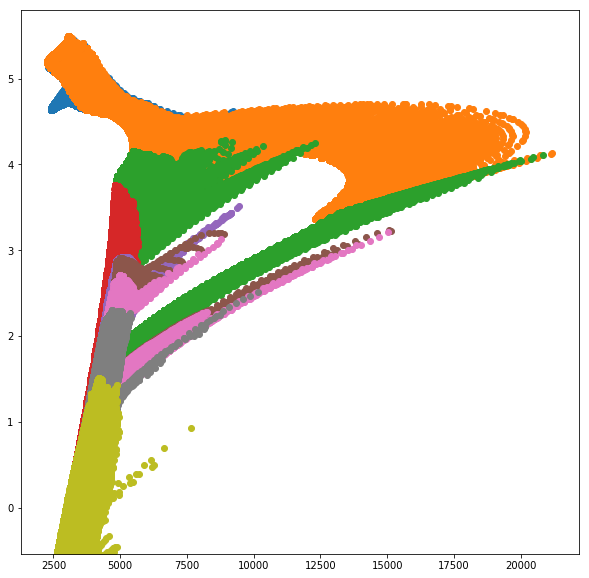

In [6]:
#####################################
### HR diagram according to group ###
#####################################

lab0 = np.where(parseciso['LABEL']==0)
lab1 = np.where(parseciso['LABEL']==1)
lab2 = np.where(parseciso['LABEL']==2)
lab3 = np.where(parseciso['LABEL']==3)
lab4 = np.where(parseciso['LABEL']==4)
lab5 = np.where(parseciso['LABEL']==5)
lab6 = np.where(parseciso['LABEL']==6)
lab7 = np.where(parseciso['LABEL']==7)
lab8 = np.where(parseciso['LABEL']==8)
lab9 = np.where(parseciso['LABEL']==9)


### Sepctroscopic HR diagram
plt.figure(figsize=[10,10])
plt.scatter(10**parseciso['LOGTE'][lab0],parseciso['LOGG'][lab0],label='0.0')
plt.scatter(10**parseciso['LOGTE'][lab1],parseciso['LOGG'][lab1],label='1.0')
plt.scatter(10**parseciso['LOGTE'][lab2],parseciso['LOGG'][lab2],label='2.0')
plt.scatter(10**parseciso['LOGTE'][lab3],parseciso['LOGG'][lab3],label='3.0')
plt.scatter(10**parseciso['LOGTE'][lab4],parseciso['LOGG'][lab4],label='4.0')
plt.scatter(10**parseciso['LOGTE'][lab5],parseciso['LOGG'][lab5],label='5.0')
plt.scatter(10**parseciso['LOGTE'][lab6],parseciso['LOGG'][lab6],label='6.0')
plt.scatter(10**parseciso['LOGTE'][lab7],parseciso['LOGG'][lab7],label='7.0')
plt.scatter(10**parseciso['LOGTE'][lab8],parseciso['LOGG'][lab8],label='8.0')
plt.scatter(10**parseciso['LOGTE'][lab9],parseciso['LOGG'][lab9],label='9.0')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'sHR Diagram')
plt.legend()
plt.show()

### Normal HR diagram
plt.figure(figsize=[10,10])
plt.scatter(10**parseciso['LOGTE'][lab0],parseciso['LOGL'][lab0],label='0.0')
plt.scatter(10**parseciso['LOGTE'][lab1],parseciso['LOGL'][lab1],label='1.0')
plt.scatter(10**parseciso['LOGTE'][lab2],parseciso['LOGL'][lab2],label='2.0')
plt.scatter(10**parseciso['LOGTE'][lab3],parseciso['LOGL'][lab3],label='3.0')
plt.scatter(10**parseciso['LOGTE'][lab4],parseciso['LOGL'][lab4],label='4.0')
plt.scatter(10**parseciso['LOGTE'][lab5],parseciso['LOGL'][lab5],label='5.0')
plt.scatter(10**parseciso['LOGTE'][lab6],parseciso['LOGL'][lab6],label='6.0')
plt.scatter(10**parseciso['LOGTE'][lab7],parseciso['LOGL'][lab7],label='7.0')
plt.scatter(10**parseciso['LOGTE'][lab8],parseciso['LOGL'][lab8],label='8.0')
plt.scatter(10**parseciso['LOGTE'][lab9],parseciso['LOGL'][lab9],label='9.0')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'HR Diagram')
plt.legend()
plt.show()

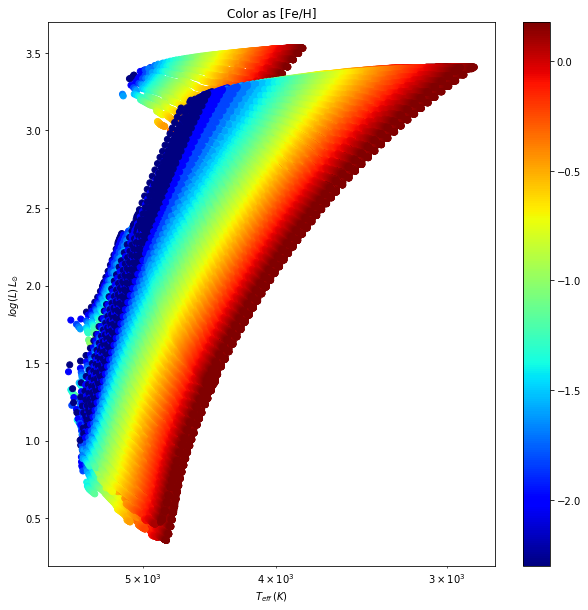

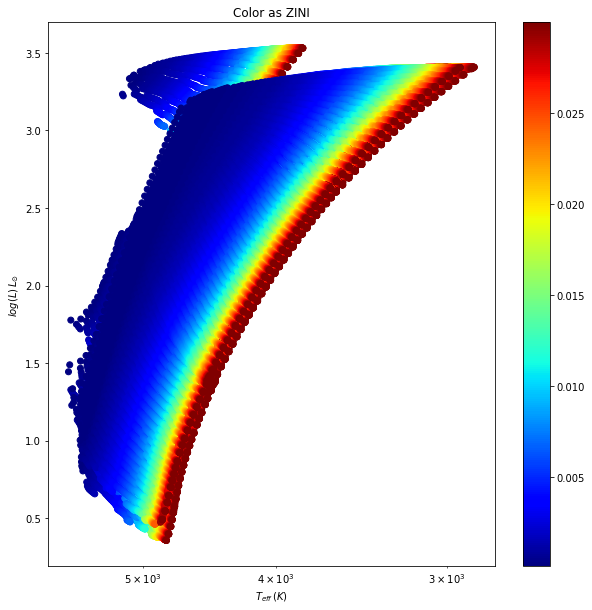

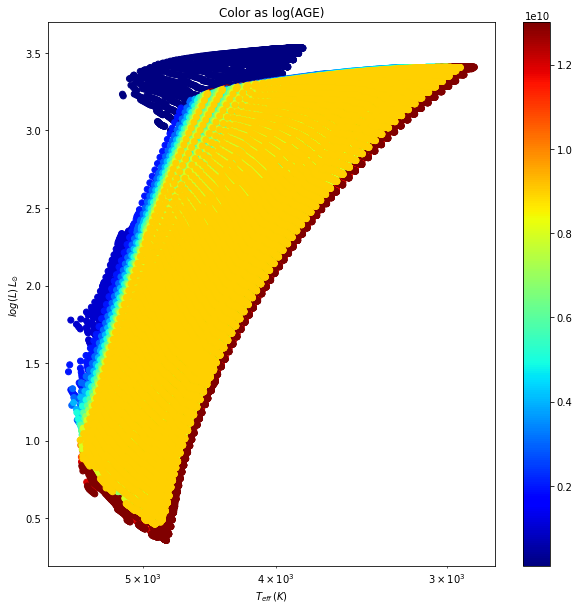

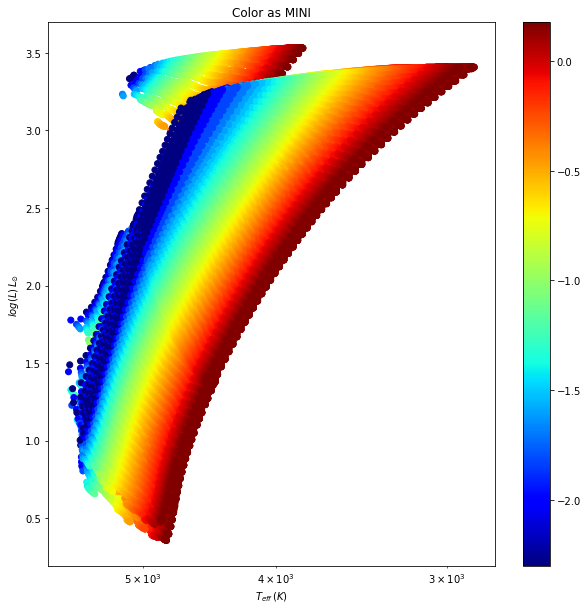

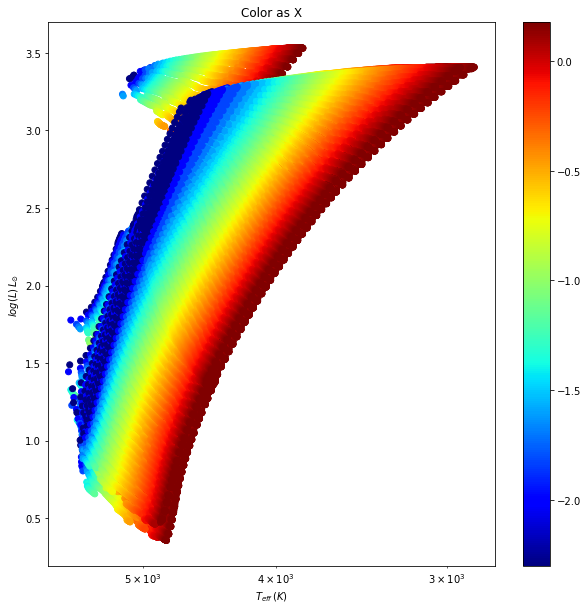

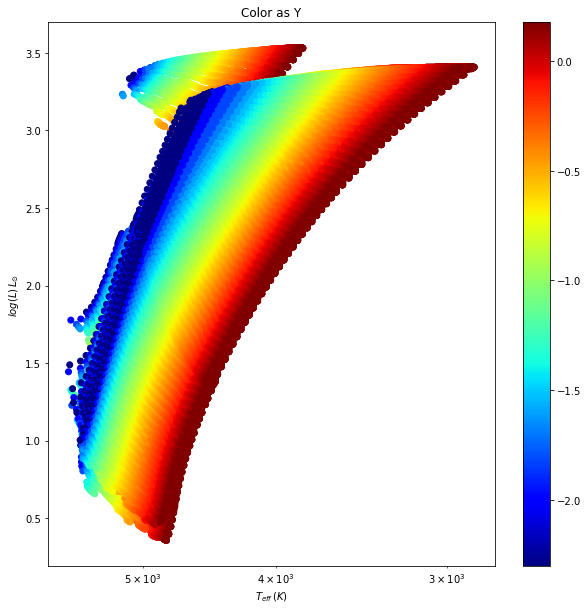

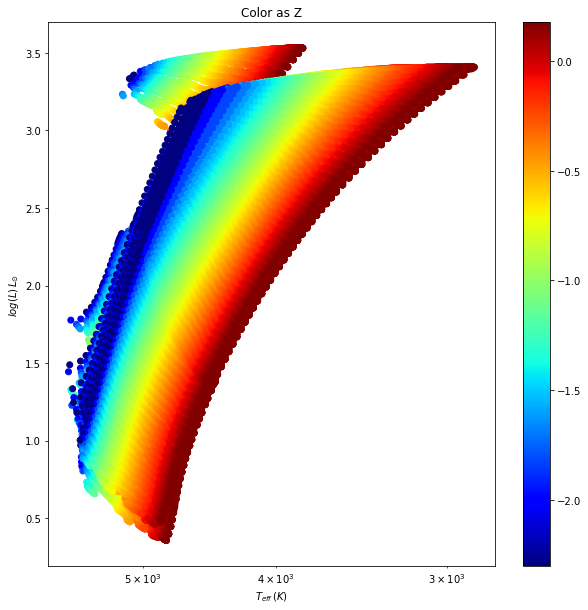

In [8]:
###########################################
### Isolated RGB Stars Normal HR PARSEC ###
###########################################

rgbiso = parseciso[lab3]
colmap = 'jet'

### Color by FEH
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as [Fe/H]')
plt.show()

### Color ZINI
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['ZINI'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as ZINI')
plt.show()

### Color by AGE
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['AGE'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as log(AGE)')
plt.show()

### Color by MINI
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as MINI')
plt.show()

### Color by X
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as X')
plt.show()

### Color by Y
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as Y')
plt.show()

### Color by Z
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGL'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'Color as Z')
plt.show()

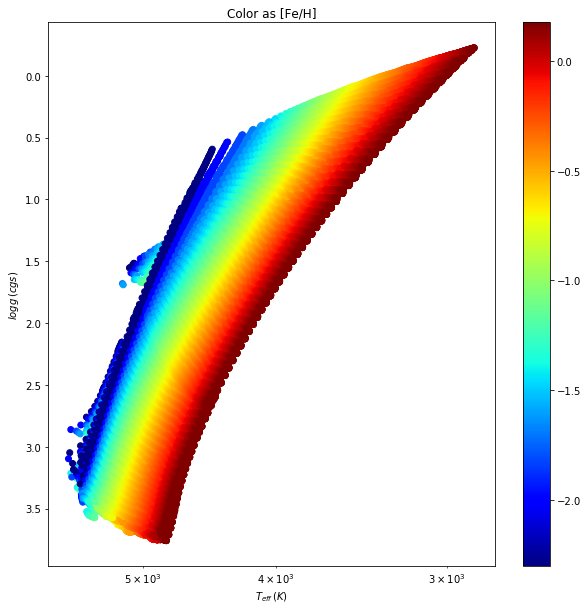

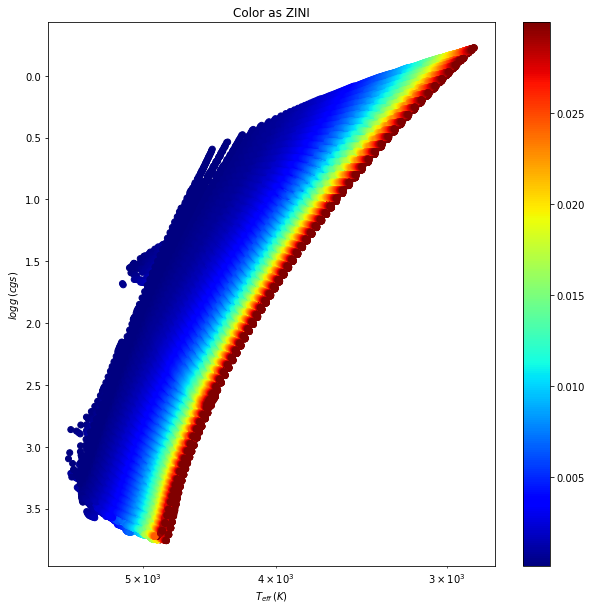

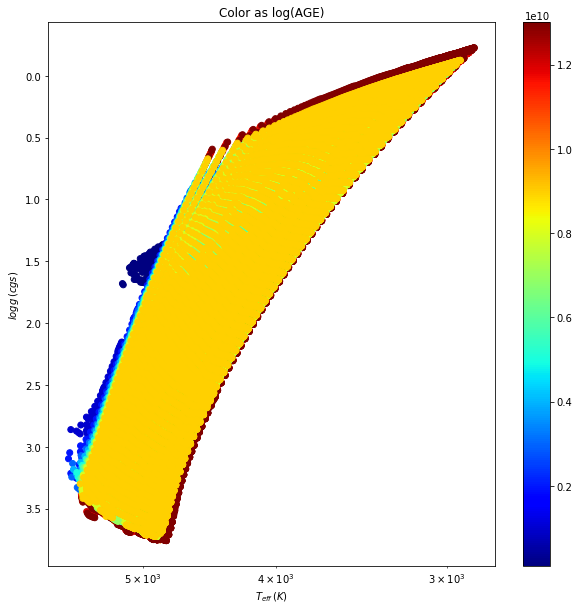

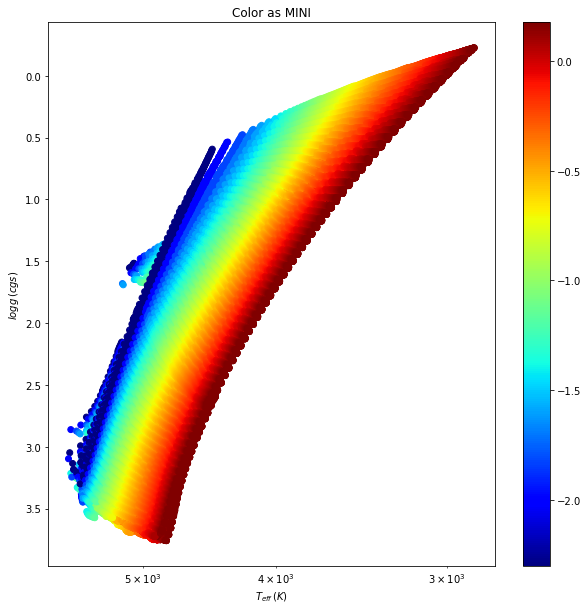

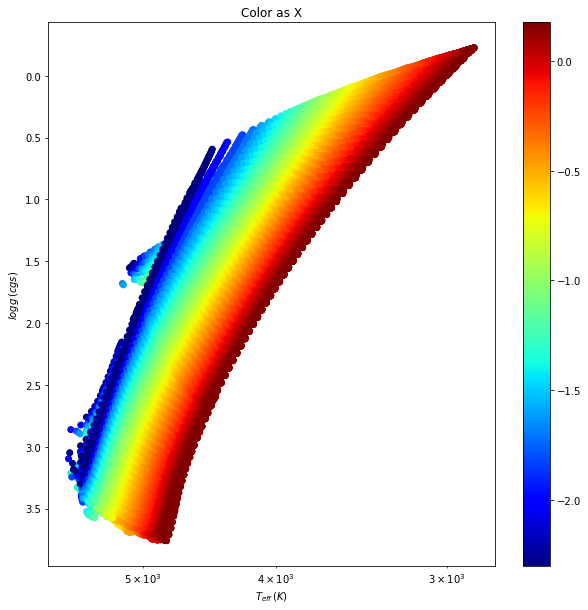

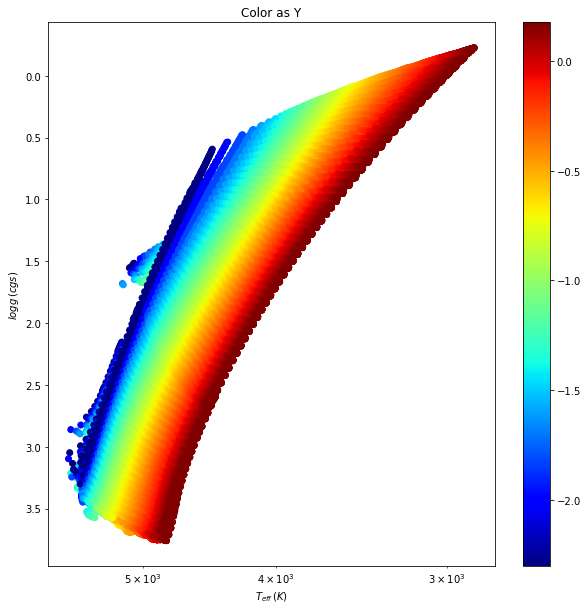

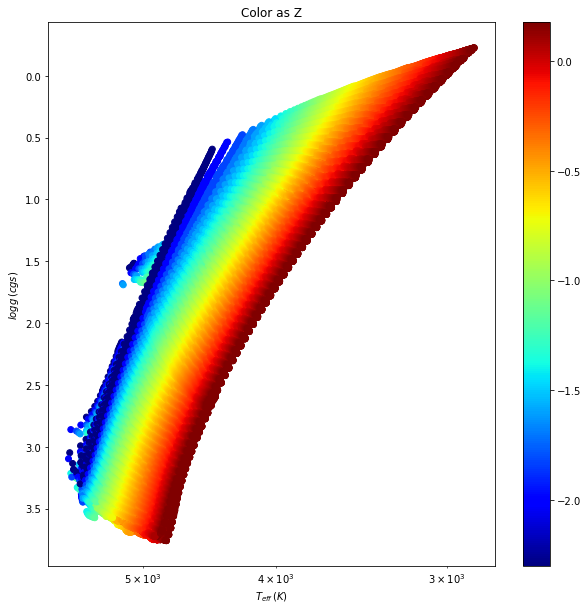

In [9]:
#####################################
### Isolated RGB Stars sHR PARSEC ###
#####################################

colmap = 'jet'

### Color by FEH
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as [Fe/H]')
plt.show()

### Color ZINI
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['ZINI'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as ZINI')
plt.show()

### Color by AGE
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['AGE'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as log(AGE)')
plt.show()

### Color by MINI
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as MINI')
plt.show()

### Color by X
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as X')
plt.show()

### Color by Y
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as Y')
plt.show()

### Color by Z
plt.figure(figsize=[10,10])
plt.scatter(10**rgbiso['LOGTE'],rgbiso['LOGG'],c=rgbiso['FEH'],cmap=colmap)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$logg\,(cgs)$')
plt.title(r'Color as Z')
plt.show()

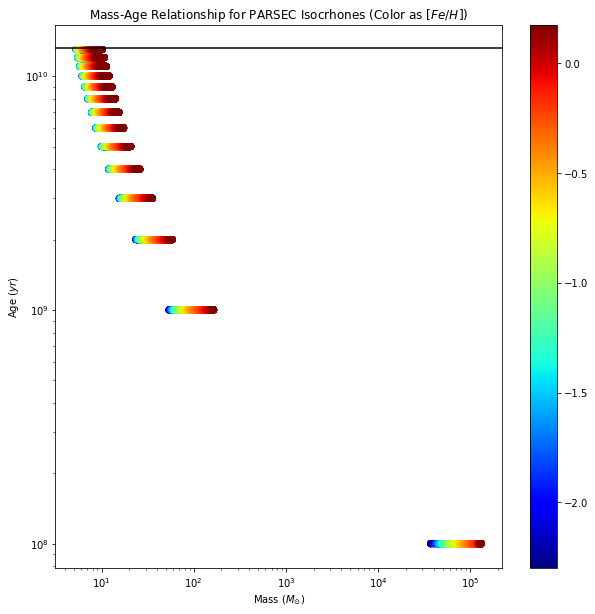

In [10]:
# plt.figure(figsize=[10,10])
# plt.scatter(10**parseciso['LOGTE'][lab3],np.log(parseciso['AGE'][lab3]),c=parseciso['FEH'][lab3],cmap=colmap)
# # plt.scatter(10**parseciso['LOGTE'],np.log(parseciso['AGE']),c=parseciso['FEH'],cmap=colmap)
# # plt.xscale('log')
# # plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.colorbar()
# plt.xlabel(r'$T_{eff}\,(K)$')
# plt.ylabel(r'$log(age)\,yr$')
# plt.title(r'Color as $[Fe/H]$')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(parseciso['FEH'][lab3],np.log(parseciso['AGE'][lab3]),c=parseciso['LOGTE'][lab3],cmap=colmap)
# # plt.scatter(10**parseciso['LOGTE'],np.log(parseciso['AGE']),c=parseciso['FEH'],cmap=colmap)
# # plt.xscale('log')
# # plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.colorbar()
# plt.xlabel(r'$[Fe/H]$')
# plt.ylabel(r'$log(age)\,yr$')
# plt.title(r'Color as $log(T_{eff})\,K$')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(parseciso['FEH'][lab3],10**parseciso['LOGTE'][lab3],c=np.log(parseciso['AGE'][lab3]),cmap=colmap)
# # plt.scatter(10**parseciso['LOGTE'],np.log(parseciso['AGE']),c=parseciso['FEH'],cmap=colmap)
# # plt.xscale('log')
# # plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.colorbar()
# plt.xlabel(r'$[Fe/H]$')
# plt.ylabel(r'$T_{eff}\,(K)$')
# plt.title(r'Color as $log(Age)\,yr$')
# plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parseciso['MASS'][lab3],(parseciso['AGE'][lab3]),c=parseciso['FEH'][lab3],cmap=colmap)
plt.xscale('log')
plt.yscale('log')
plt.axhline(ageU,c='k')
#plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Mass $(M_{\odot})$')
plt.ylabel(r'Age $(yr)$')
plt.title(r'Mass-Age Relationship for PARSEC Isocrhones (Color as $[Fe/H]$)')
plt.show()

In [11]:
iso100Myr = np.where(parseciso['AGE']==100000000.0) 
iso1Gyr = np.where(parseciso['AGE']==1000000000.0) 
iso2Gyr = np.where(parseciso['AGE']==2000000000.0)
iso3Gyr = np.where(parseciso['AGE']==3000000000.0)
iso4Gyr = np.where(parseciso['AGE']==4000000000.0)
iso5Gyr = np.where(parseciso['AGE']==5000000000.0)
iso6Myr = np.where(parseciso['AGE']==6000000000.0)
iso7Gyr = np.where(parseciso['AGE']==7000000000.0)
iso8Gyr = np.where(parseciso['AGE']==8000000000.0)
iso9Gyr = np.where(parseciso['AGE']==9000000000.0)
iso10Gyr = np.where(parseciso['AGE']==10000000000.0)
iso11Gyr = np.where(parseciso['AGE']==11000000000.0)
iso12Gyr = np.where(parseciso['AGE']==12000000000.0)
iso13Gyr = np.where(parseciso['AGE']==13000000000.0)

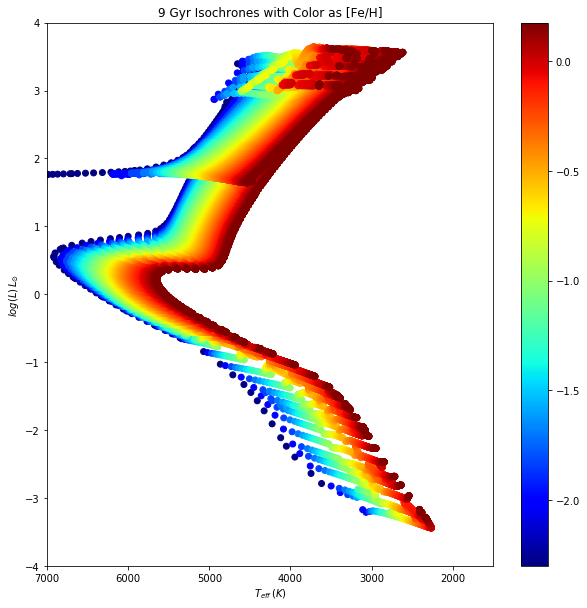

In [12]:
plt.figure(figsize=[10,10])
plt.scatter(10**parseciso['LOGTE'][iso9Gyr],parseciso['LOGL'][iso9Gyr],c=parseciso['FEH'][iso9Gyr],cmap=colmap)
#plt.xscale('log')
plt.xlim(1500,7000)
plt.ylim(-4,4)
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'$T_{eff}\,(K)$')
plt.ylabel(r'$log(L)\,L_{\odot}$')
plt.title(r'9 Gyr Isochrones with Color as [Fe/H]')
plt.show()

In [13]:
lmc58297.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '60A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '29A'
    name = 'NINST'; format = '3J'
    name = 'NV

In [18]:
# ############################
# ### RGB Stars sHR APOGEE ###
# ############################

# colmap = 'jet'
# abundances = [lmc58297['M_H'],lmc58297['C_FE'],lmc58297['CI_FE'],lmc58297['N_FE'],lmc58297['O_FE'],lmc58297['NA_FE'],lmc58297['MG_FE'],lmc58297['AL_FE'],lmc58297['SI_FE'],lmc58297['P_FE'],lmc58297['S_FE'],lmc58297['K_FE'],lmc58297['CA_FE'],lmc58297['TI_FE'],lmc58297['TIII_FE'],lmc58297['V_FE'],lmc58297['CR_FE'],lmc58297['MN_FE'],lmc58297['FE_H'],lmc58297['CO_FE'],lmc58297['NI_FE']]
# titles = ['M/H','C/Fe','CI/Fe','N/Fe','O/Fe','Na/Fe','Mg/Fe','Al/Fe','Si/Fe','P/Fe','S/Fe','K/Fe','Ca_Fe','Ti/Fe','TiII/Fe','V/Fe','Cr/Fe','Mn/Fe','Fe/H','Co/Fe','Ni/Fe']
    
# plt.figure(figsize=[10,10])
# plt.scatter(lmc58297['TEFF'],lmc58297['LOGG'],c=lmc58297['ALPHA_M']+lmc58297['M_H'],cmap=colmap)
# plt.xscale('log')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.colorbar()
# plt.xlabel(r'$T_{eff}\,(K)$')
# plt.ylabel(r'$logg\,(cgs)$')
# plt.title(r'Color as $[\alpha/M]$')
# plt.show()

# for i in range(len(abundances)):
#     plt.figure(figsize=[10,10])
#     cln = np.where((abundances[i]>-100)&(abundances[i]<100))
#     plt.scatter(lmc58297['TEFF'][cln],lmc58297['LOGG'][cln],c=abundances[i][cln],cmap=colmap)
#     plt.xscale('log')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
#     plt.colorbar()
#     plt.xlabel(r'$T_{eff}\,(K)$')
#     plt.ylabel(r'$logg\,(cgs)$')
#     plt.title(r'Color as [{}]'.format(titles[i]))
#     plt.show()

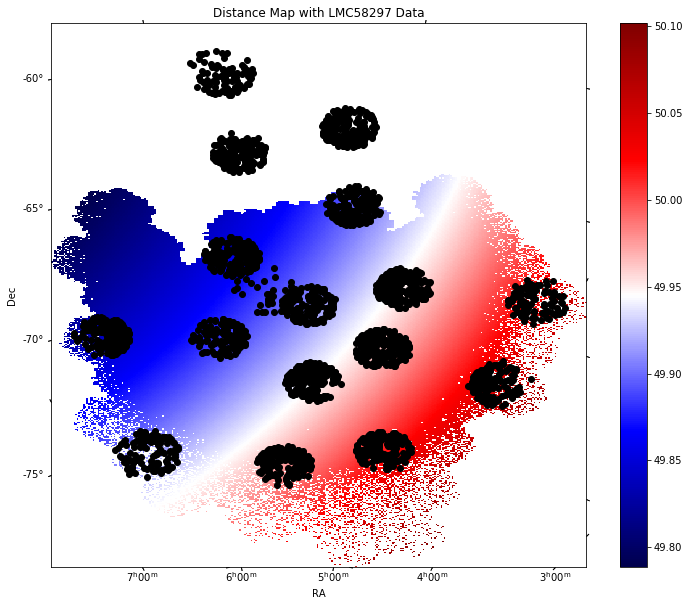

In [17]:
########################
### LMC Distance Map ###
########################

from astropy.wcs import wcs

hdulist = fits.open(filepath3)
hdu = fits.getdata(filepath3,0)
w = wcs.WCS(hdulist[0].header)

px, py = w.wcs_world2pix(lmc58297['RA'],lmc58297['DEC'], 0)

fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()
plt.imshow(hdu+49.9, origin='lower', cmap=plt.cm.seismic,aspect='auto')
plt.colorbar()
plt.scatter(px,py,c='k')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(r'Distance Map with LMC58297 Data')
plt.gca().invert_xaxis()
plt.savefig('distLMC58297.pdf',bbox_inches='tight')

In [66]:
######################################
### Absolute Magnitudes Calculated ###
######################################
'''Not Using distance map'''

a, b, c = dist2LMC(lmc58297['RA'],lmc58297['DEC'])

absH = absmag(lmc58297['H'],c,par=False)
absJ = absmag(lmc58297['J'],c,par=False)


In [67]:
print(absH)

[-5.96571065 -6.10376531 -6.03376483 ... -5.69983886 -4.3256593
 -4.67293718]


In [68]:
print(absJ)

[-5.10070993 -5.206765   -5.1987648  ... -4.91983913 -3.52265885
 -4.01393773]


In [43]:
print(lmc58297['DEC'])

[-1.12497515e-07 -1.13055301e-07 -1.12755607e-07 ... -9.86529900e-08
 -9.72689174e-08 -9.71127809e-08]
